In [1]:
%matplotlib widget
import os
import io
import pickle
import contextlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from omars_little_helpers import *
from ode_system import *
import pandas as pd
import seaborn as sns

/var/folders/wn/k16m1d894ng_58sbvv687rhm0000gn/T/ipykernel_57541/1717255385.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## 1) Import GR Solutions

In [2]:
GR_file_path = './output/GR/GR_full_star_solution.pkl'

with open(GR_file_path, 'rb') as file:
    GR_results = pickle.load(file)

data = []
# Loop through each result in GR_results
for star in GR_results:
    # Extract needed values
    rho_c = star['rho_c']  # Assuming this is directly available as 'rho_c'
    radius = star['radius']
    mass = star['mass']
    
    # Append the data to the list
    data.append({
        'rho_c': rho_c,
        'radius': radius,
        'mass': mass
    })

# Assuming GR_results is structured similarly to axion star data
GR_identifier = [('GR', i) for i in range(len(GR_results))]  # Creating identifiers for GR data

# Modify GR data to fit the structure
GR_modified_data = [{
    'identifier': identifier,
    'rho_c': star['rho_c'],
    'a_c': None,  # Assuming no 'a_c' in GR data, set as None or appropriate default
    'mass': star['mass'],
    'radius': star['radius']
} for identifier, star in zip(GR_identifier, GR_results)]


In [3]:
# import star data
run_name = []
dir_to_sol = []
results = []

for dirname,_,filenames in os.walk('./output'):
    if '50_stars' not in dirname:
        for filename in filenames:
            if filename.endswith('full_star_solutions.pkl'):
                print(os.path.join(dirname,filename))
                dir_to_sol.append(os.path.join(dirname,filename))
                run_name.append(dirname.split('/')[-1])

for dir in dir_to_sol:
    with open(dir, 'rb') as file:
        result = pickle.load(file)
        results.append(result)
    

./output/default_full_star_solutions.pkl
./output/EW_axions/EW_axions_full_star_solutions.pkl
./output/ma15_gsN9e-25/ma15_mu1e24_full_star_solutions.pkl
./output/ma16_gsN9e-25/ma16_mu1e24_full_star_solutions.pkl


In [4]:
# initialize a list to store combined data
axion_data = []

# continue using the array_solutions dictionary for array data
array_solutions = {key: {} for key in ['rho', 'a_in', 'a_out', 'a_prime_in', 'a_prime_out', 'nu_in', 'nu_out', 'llambda_in', 'llambda_out', 'r_inside', 'r_outside']}

# process data
for run_idx, (run, result) in enumerate(zip(run_name, results)):
    for star_idx, star_data in enumerate(result):
        # Create a unique identifier for each star in each run
        identifier = (run, star_idx)
        
        # combine scalar data for DataFrame
        axion_data.append({
            'identifier': identifier,
            'rho_c': star_data['rho'][0],  # first entry of rho
            'a_c': star_data['a_c'],
            'mass': star_data['mass'],
            'radius': star_data['radius']
        })
        
        # store array solutions
        for key in array_solutions.keys():
            array_solutions[key][identifier] = star_data[key]
axion_data.extend(GR_modified_data)

# Create a single DataFrame
combined_df = pd.DataFrame(axion_data).set_index('identifier')
combined_df.index = pd.MultiIndex.from_tuples(combined_df.index, names=['run_name', 'star_id'])

# Reorder DataFrame columns as requested
combined_df = combined_df[['rho_c', 'a_c', 'mass', 'radius']]


# Now, you have:
# - combined_df: A DataFrame with scalar values and rho_c[0] for all runs and stars
# - array_solutions: A dictionary with nested dictionaries for array solutions

# Example of accessing scalar data:
# To get the mass and radius of the first star in the first run:
# first_run_star_info = combined_df.loc[(run_name[0], 0), ['mass', 'radius']]

# To get the 'rho' array of the first star in the first run:
# first_run_star_rho = array_solutions['rho'][(run_name[0], 0)]



In [5]:
run_name

['output', 'EW_axions', 'ma15_gsN9e-25', 'ma16_gsN9e-25']

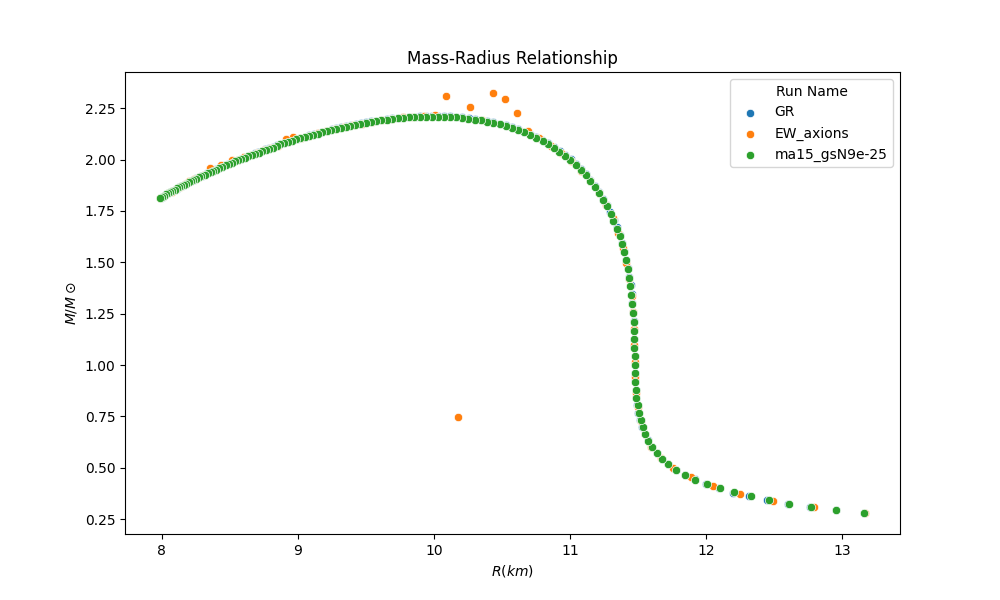

In [41]:
selected_runs = ['GR', 'EW_axions','ma15_gsN9e-25']  # Add or remove run names as needed

# Set the figure size for better readability
plt.figure(figsize=(10, 6))

# Iterate over each selected run_name to plot its mass vs. radius curve
for name in selected_runs:
    # Filter the DataFrame for the current name
    subset_df = combined_df.loc[name]
    
    # Plot mass vs. radius for the current name
    # Normalize radius as requested (R/1e5) and assume mass is already normalized (M/M_odot)
    sns.scatterplot(x=subset_df['radius']/1e5, y=subset_df['mass'], label=name)
# Set the plot labels and title
plt.xlabel(r'$R (km)$')
plt.ylabel(r'$M/M\odot$')
plt.title('Mass-Radius Relationship')
plt.legend(title='Run Name')
#plt.xlim(8,13)
#plt.ylim(0.25,2.25)

plt.show()

In [7]:
run_name

['output', 'EW_axions', 'ma15_gsN9e-25', 'ma16_gsN9e-25']

In [8]:
run_to_plot = run_name[1]

for idx in range(len(combined_df.loc[run_to_plot])):
    a_out_i = array_solutions['a_out'][(run_to_plot,idx)]
    if abs(a_out_i[-1])>1e-10:
        print(f"For star {idx}, a'(r_far) = {a_out_i[-1]}")


For star 0, a'(r_far) = -8.023946081992308e-09
For star 1, a'(r_far) = -1.684220077503872e-08
For star 2, a'(r_far) = -3.4332843307665455e-08
For star 3, a'(r_far) = -7.423229869657314e-09
For star 4, a'(r_far) = -1.635310358021417e-08
For star 5, a'(r_far) = -3.520801619508939e-08
For star 6, a'(r_far) = -7.353327307898038e-08
For star 7, a'(r_far) = -2.4506170797824045e-08
For star 8, a'(r_far) = -5.454677711748313e-08
For star 9, a'(r_far) = -1.1731668558856644e-07
For star 10, a'(r_far) = -2.60838119739163e-08
For star 11, a'(r_far) = -5.3812617453141974e-08
For star 12, a'(r_far) = -1.6175661185483642e-08
For star 13, a'(r_far) = -3.517509665893384e-08
For star 15, a'(r_far) = -7.170081848370956e-07
For star 24, a'(r_far) = -8.393627133690579e-08
For star 27, a'(r_far) = -1.835640855636677e-08
For star 29, a'(r_far) = -7.643965873283699e-08
For star 30, a'(r_far) = -5.811944476082428e-07
For star 31, a'(r_far) = 2.2477747075432836e-10
For star 32, a'(r_far) = 1.170754783968245e-06

In [9]:
run_to_plot

'EW_axions'

In [46]:
combined_df.loc[('EW_axions',38)].rho_c

2481459374999809.5

Star of rho_c = 2.604e+15 ---> M,R = (2.310 Solar Masses	,	 10.090372452620535 km) 


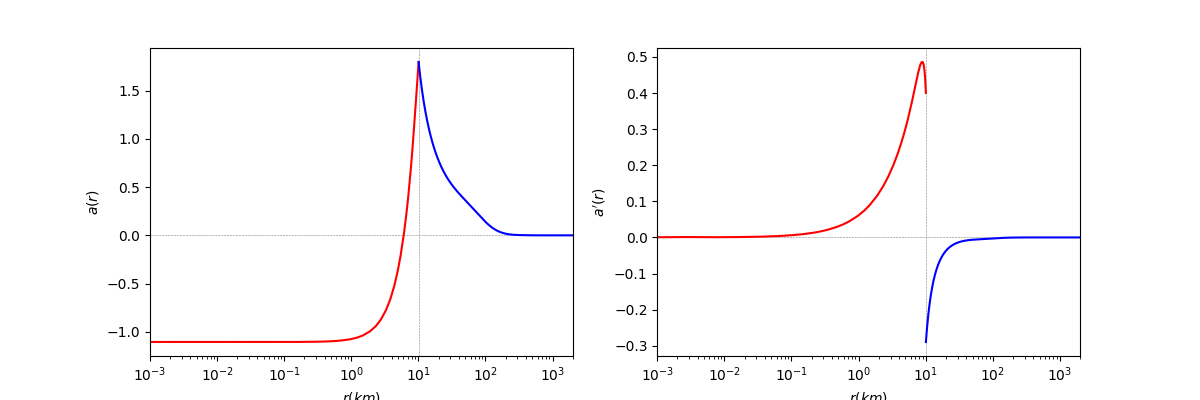

In [43]:
idx = 39
r_in = array_solutions['r_inside'][(run_to_plot,idx)]
r_out = array_solutions['r_outside'][(run_to_plot,idx)]
nu_out = array_solutions['nu_out'][(run_to_plot,idx)]


radius = combined_df.loc[(run_to_plot, idx), 'radius']
mass = combined_df.loc[(run_to_plot, idx), 'mass']
rho_c = combined_df.loc[(run_to_plot, idx), 'rho_c']


print(f"Star of rho_c = {rho_c:0.3e} ---> M,R = ({mass:0.3f} Solar Masses\t,\t {radius/1e5} km) ")
plt.close('all')

# set the figure size large enough to accommodate two side-by-side plots
plt.figure(figsize=(12, 4))  

plot_full_side_by_side(r_in, r_out, radius, array_solutions['a_in'][(run_to_plot,idx)], array_solutions['a_out'][(run_to_plot,idx)], 'a(r)', subplot_index=1)
plot_full_side_by_side(r_in, r_out, radius, array_solutions['a_prime_in'][(run_to_plot,idx)], array_solutions['a_prime_out'][(run_to_plot,idx)], 'a\'(r)', subplot_index=2)

#plt.savefig("optimized_ac.pdf")
plt.show()

In [10]:
# chris' mass
# Interpolate nu_out over a finer grid
r_fine = np.linspace(r_out[0], r_out[-1], 100000)  # Define a finer grid
nu_interp = interp1d(r_out, nu_out, kind='cubic')  # Cubic interpolation

# Estimate the derivative using finite differences
nu_prime_out = np.gradient(nu_interp(r_fine), r_fine)[-1]  # Estimate derivative at the boundary

# Calculate the mass
mass = (c**2 * r_out[-1]**2 * nu_prime_out) / (2 * G * (1 + nu_prime_out * r_out[-1])) / Msun
print("Estimated Mass:", mass)

Estimated Mass: 0.2942277418689169


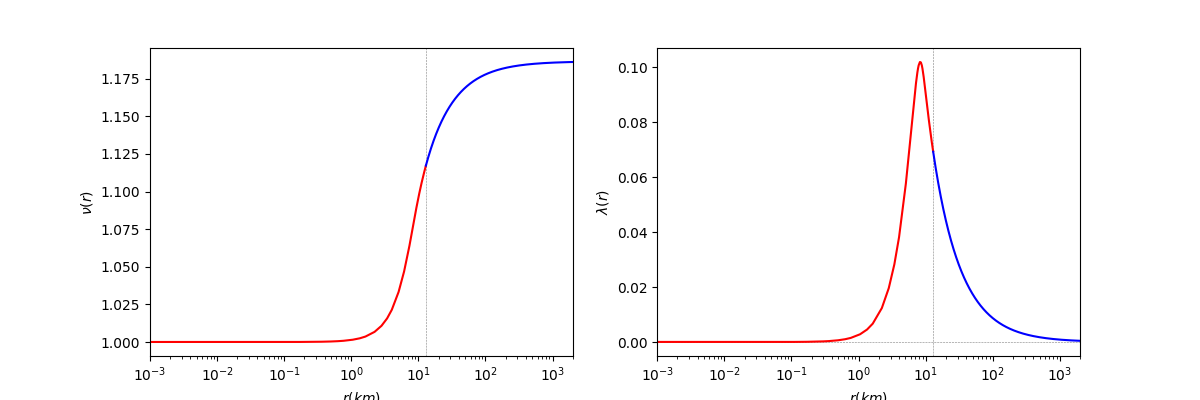

In [12]:
plt.close('all')

# set the figure size large enough to accommodate two side-by-side plots
plt.figure(figsize=(12, 4))  

plot_full_side_by_side(r_in, r_out, radius, array_solutions['nu_in'][(run_to_plot,idx)], array_solutions['nu_out'][(run_to_plot,idx)], r"\nu(r)", subplot_index=1)
plot_full_side_by_side(r_in, r_out, radius, array_solutions['llambda_in'][(run_to_plot,idx)], array_solutions['llambda_out'][(run_to_plot,idx)], "\lambda(r)", subplot_index=2)

plt.show()

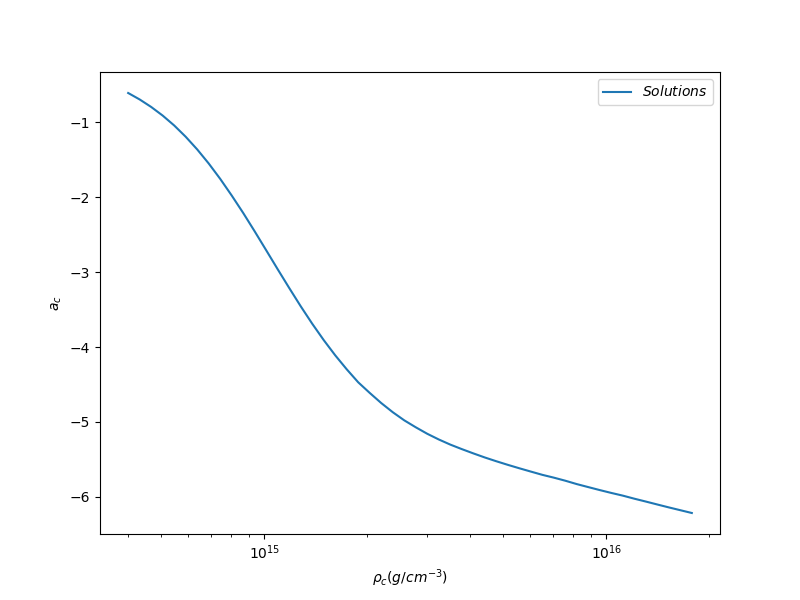

In [31]:
plt.close('all')
fig = plt.figure(figsize=(8, 6))
ax = plt.gca()
ax.plot(ax_rho_c, ax_a_c, label=r"$Solutions$")
#ax.plot(ax_rho_c, a_minimized, label=r"$Min(V_{eff})$")
ax.set_xlabel(r"$\rho_c (g/cm^{-3})$")
ax.set_ylabel(r"$a_c$");
ax.set_xscale("log")
plt.legend()